In [1]:
# Use networkx to create a graph with the relations
import networkx as nx
import random
from math import log10
from udpipe2_tuples_generator import run_sequential, break_text_into_sentences, get_all_text_from_folder

import matplotlib.pyplot as plt

def plot_graph(tuples, name, interesting_subjects = []):
    G = nx.Graph()
    number_of_objects_per_subject = [0, 0]
    random.shuffle(tuples)
    for tuple in tuples:
        subject = tuple[0]
        relation = tuple[1]
        object_ = tuple[2]
        if subject in interesting_subjects and number_of_objects_per_subject[interesting_subjects.index(subject)] < 10:
            G.add_edge(subject, object_, relation=relation)
            number_of_objects_per_subject[interesting_subjects.index(subject)] += 1

    plt.figure(figsize=(30,30))
    pos = nx.spring_layout(G, k=0.5)
    nx.draw_networkx_nodes(G, pos, node_size=1000, node_color='g')
    if len(interesting_subjects) > 0:
        nx.draw_networkx_nodes(G, pos, nodelist=[n for n in G.nodes() if n in interesting_subjects], node_size=1000, node_color='r')
    nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.5)
    nx.draw_networkx_labels(G, pos, font_size=16)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=nx.get_edge_attributes(G, 'relation'), font_size=16)

    plt.axis('off')
    plt.savefig(name + '.png', dpi=300)


In [2]:
# Create the final graph with all the nodes and edges
def create_graph(tuples):
    G = nx.Graph()
    for string_tuple in tuples:
        subject = string_tuple[0]
        relation = string_tuple[1]
        object_ = string_tuple[2]
        G.add_edge(subject, object_, relation=relation)
    return G

In [3]:
def get_all_shortest_paths(tuples):
    global G
    all_shortest_paths = []
    for tuple in tuples:
        source = tuple[0]
        relation = tuple[1]
        target = tuple[2]
        try:
            for path in nx.all_shortest_paths(G, source=source, target=target):
                all_shortest_paths.append([path, relation])
        except (nx.NetworkXNoPath, nx.NodeNotFound):
            pass
    return all_shortest_paths

def rate_sentence(sentence):
    string_tuples = run_sequential(sentence)
    all_shortest_paths = get_all_shortest_paths(string_tuples)

    if len(all_shortest_paths) == 0:
        return 0

    def rate_path(path, relation):
        global G
        if len(path) == 2:
            return 1
        
        score = 1 / (1 + sum([log10(G.degree(node)) for node in path[1:-1]]))

        # # add 1 to the score if relation appers in the path
        # if relation in path:
        #     score += 1
        
        return score
    
    return sum([rate_path(path, relation) for [path, relation] in all_shortest_paths])/len(all_shortest_paths)

def rate_text(text):
    sentences = break_text_into_sentences(text)
    return sum([rate_sentence(sentence) for sentence in sentences]) / len(sentences)
        

In [4]:
import threading
from tqdm.notebook import tqdm

def rate_texts_threaded(start, end, master):
    global df
    if master:
        for index, row in tqdm(df.iloc[start:end].iterrows(), total=end-start, unit='rows', mininterval=1, desc='[Master] Rating texts'):
            df.loc[index, 'rating'] = rate_text(df.loc[index, 'content'])
    else:
        for index, row in df.iloc[start:end].iterrows():
            df.loc[index, 'rating'] = rate_text(df.loc[index, 'content'])

def run_with_threads():
    global df
    number_of_threads = 24
    number_of_rows = df.shape[0]
    threads = []
    for i in range(number_of_threads):
        start = int(i * number_of_rows // number_of_threads)
        end = int((i + 1) * number_of_rows // number_of_threads) if i != number_of_threads - 1 else number_of_rows
        threads.append(threading.Thread(target=rate_texts_threaded, args=(start,end, i==number_of_threads-1)))
        threads[-1].start()

    for thread in threads:
        thread.join()

In [5]:
import pandas as pd

tuples_g1 = pd.read_csv('../data/csvs/g1_tuples_udpipe.csv').values.tolist()
tuples_fakebr = pd.read_csv('../data/csvs/fake_br_corpus_tuples_udpipe.csv').values.tolist()

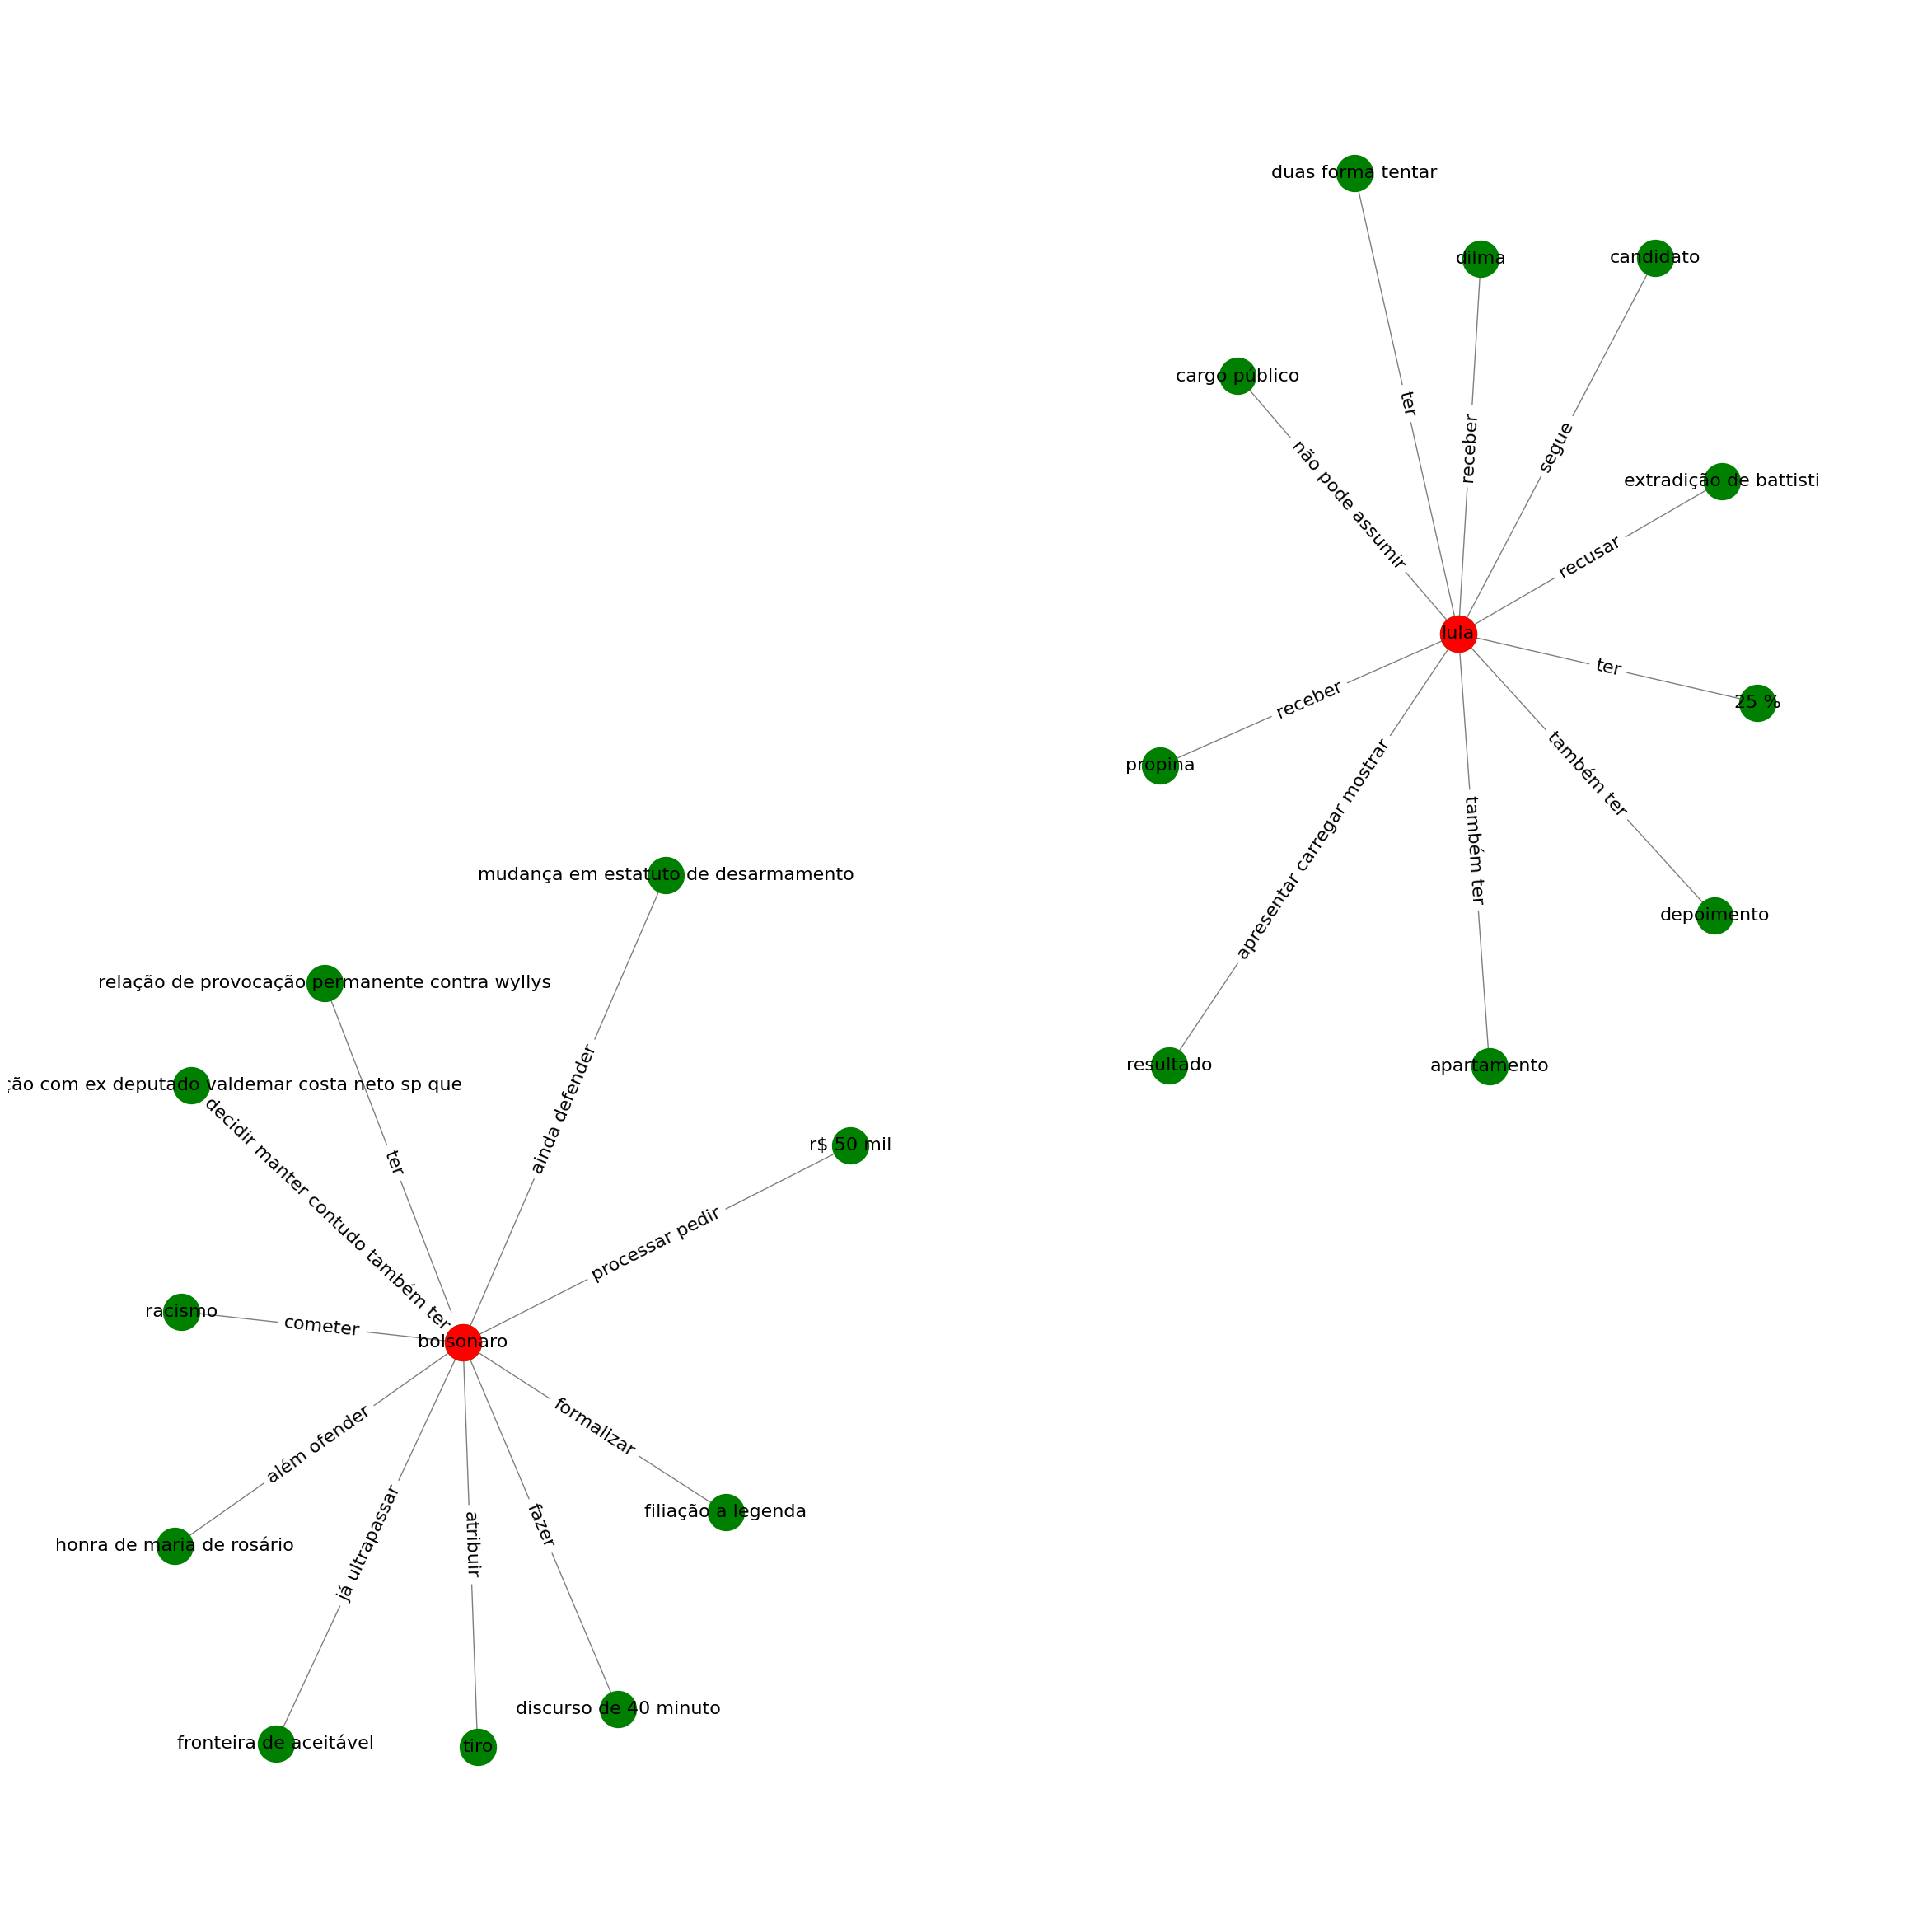

In [6]:
interesting_subjects = ['lula', 'bolsonaro']
plot_graph(tuples_fakebr, 'g1_graph_lula_bolsonaro', interesting_subjects)

In [7]:
fake_texts_df = get_all_text_from_folder('../data/text_files/full_texts/fake')
true_texts_df = get_all_text_from_folder('../data/text_files/full_texts/true')
fake_texts_df['label'] = 0
true_texts_df['label'] = 1
test_df = pd.concat([fake_texts_df, true_texts_df])

# shuffle the dataframe
test_df = test_df.sample(frac=1, random_state=42).reset_index(drop=True)
test_df.head()


,content,label
0,chorando as pitangas: bonner posta frase de do...,0
1,"na bahia, adolescente de 14 anos prevê a própr...",0
2,"segunda-feira, 12 de março. bom dia! aqui estã...",1
3,"a insanidade de lula: se me prenderem, eu viro...",0
4,criança apanha de mulher petista só porque usa...,0


In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(test_df['content'], test_df['label'], shuffle=True, test_size=0.2, random_state=42)
train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)

train.head()

,content,label
2034,﻿juiz determina soltura de 4 presos por pensão...,1
3250,"pivô do mensalão, jefferson não assistiu à tra...",1
3366,oficial da reserva avisa: se a lei do impeachm...,0
1423,bolsonaro vai para o psl e liberais abandonam ...,1
122,"por maioria de votos, os ministros da 2.a tur...",1


In [19]:
df = train.copy()
G = create_graph(tuples_fakebr)
run_with_threads()
train = df.copy()

[Master] Rating texts:   0%|          | 0/240 [00:00<?, ?rows/s]

In [11]:
df = test.copy()
G = create_graph(tuples_fakebr)
run_with_threads()
test = df.copy()

[Master] Rating texts:   0%|          | 0/60 [00:00<?, ?rows/s]

In [23]:
print(f'Train has {train.shape[0]} rows, with {train["rating"].isna().sum()} NaN values. Test has {test.shape[0]} rows, with {test["rating"].isna().sum()} NaN values.')
train.dropna(inplace=True)
test.dropna(inplace=True)
train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

Train has 5760 rows, with 0 NaN values. Test has 1440 rows, with 0 NaN values.


The average rating for fake news is 0.020605180574336947 (0.04652447177210153) while the average rating for true news is 0.04006992211915246 (0.05481750287947271)


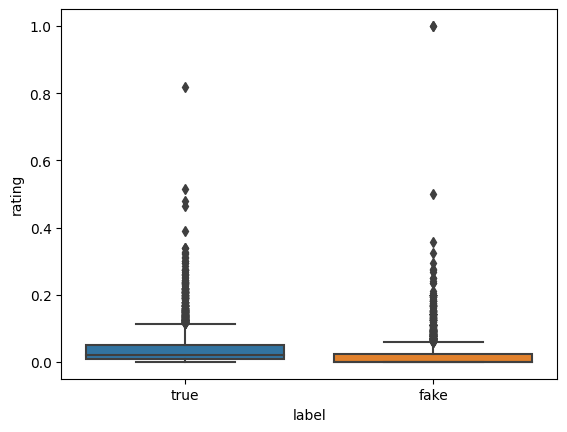

In [35]:
avg_rating_fake = train[train['label'] == 0]['rating'].mean()
std_rating_fake = train[train['label'] == 0]['rating'].std()
avg_rating_true = train[train['label'] == 1]['rating'].mean()
std_rating_true = train[train['label'] == 1]['rating'].std()
print(f'The average rating for fake news is {avg_rating_fake} ({std_rating_fake}) while the average rating for true news is {avg_rating_true} ({std_rating_true})')

# Create a boxplot to compare the ratings of fake and true news
import seaborn as sns
box_data = train.copy()
box_data['label'] = box_data['label'].replace({0: 'fake', 1: 'true'})
sns.boxplot(x='label', y='rating', data=box_data)
plt.savefig('true-fake-boxplot.png', dpi=300)

# classify the news based on the rating using a likelihood ratio test 
from scipy.stats import norm, chi2

def classify_news(rate):
    global avg_rating_fake, std_rating_fake, avg_rating_true, std_rating_true, cant_classify_count
    likelihood_fake = norm.pdf(rate, loc=avg_rating_fake, scale=std_rating_fake)
    likelihood_true = norm.pdf(rate, loc=avg_rating_true, scale=std_rating_true)
    rate = likelihood_fake / likelihood_true

    critical_value = chi2.ppf(q=0.95, df=1)
    if rate > critical_value:
        if rate < 1:
            return 1
        else:
            return 0
    else:
        # we can't classify the news, but we do it anyway
        cant_classify_count += 1
        if rate < 1:
            return 1
        else:
            return 0

In [33]:
cant_classify_count = 0
test['predicted_label'] = test['rating'].apply(classify_news)

# save to csv train and test
train.to_csv('../data/csvs/train.csv', index=False)
test.to_csv('../data/csvs/test.csv', index=False)


In [34]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

print(f'We could not classify with confidence {cant_classify_count} news.')
print(f'Accuracy: {accuracy_score(test["label"], test["predicted_label"])}')
print(classification_report(test['label'], test['predicted_label']))

We could not classify with confidence 1440 news.
Accuracy: 0.5805555555555556
              precision    recall  f1-score   support

           0       0.55      0.87      0.67       723
           1       0.69      0.29      0.41       717

    accuracy                           0.58      1440
   macro avg       0.62      0.58      0.54      1440
weighted avg       0.62      0.58      0.54      1440

